In [130]:

import pandas as pd
import numpy as np

 
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [113]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [114]:
data_unloaded = "./datasets/unloaded-res.csv"
data_loaded = "./datasets/loaded-res.csv"
unloaded_df = pd.read_csv(data_unloaded)
loaded_df = pd.read_csv(data_loaded)

In [115]:
unloaded_df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1.001,501,501,237,10110,19648,21828,22036
1,2.000,500,499,192,293,423,3846,6852
2,3.000,500,501,182,257,312,666,2641
3,4.001,500,500,168,253,313,799,1718
4,5.000,500,500,172,226,277,513,1896


In [116]:
loaded_df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1.000,3509,3508,164,93238,139150,148184,150063
1,2.000,3509,3509,129,178,219,495,880
2,3.000,3511,3511,130,165,204,588,2634
3,4.000,3508,3509,124,165,196,485,1038
4,5.001,3507,3506,127,169,203,350,863


In [120]:
unloaded_df['delta_throughput'] = df['sent'] - df['received']
loaded_df['delta_throughput'] = df['sent'] - df['received']


In [121]:
unloaded_df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th,delta_throughput
0,1.001,501,501,237,10110,19648,21828,22036,0
1,2.000,500,499,192,293,423,3846,6852,1
2,3.000,500,501,182,257,312,666,2641,-1
3,4.001,500,500,168,253,313,799,1718,0
4,5.000,500,500,172,226,277,513,1896,0


In [122]:
loaded_df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th,delta_throughput
0,1.000,3509,3508,164,93238,139150,148184,150063,0
1,2.000,3509,3509,129,178,219,495,880,1
2,3.000,3511,3511,130,165,204,588,2634,-1
3,4.000,3508,3509,124,165,196,485,1038,0
4,5.001,3507,3506,127,169,203,350,863,0


In [123]:
unloaded_df.describe()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th,delta_throughput
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,6300.500181,3508.248095,3508.223016,123.017937,297.474683,808.008095,5768.849921,12152.752381,0.025079
std,3637.451168,1955.396494,1955.958114,12.814470,221.138276,1186.320077,13249.194464,20633.738050,48.214572
min,1.001000,480.000000,478.000000,93.000000,166.000000,185.000000,267.000000,324.000000,-1174.000000
25%,3150.750000,2000.000000,2000.000000,114.000000,198.000000,293.000000,520.000000,1375.000000,-1.000000
50%,6300.500000,4000.000000,4000.000000,120.000000,220.000000,448.500000,1763.500000,4711.500000,0.000000
75%,9450.250750,6022.000000,6010.000000,128.000000,326.000000,818.000000,5033.500000,11890.500000,1.000000
max,12600.001000,6726.000000,7197.000000,237.000000,10110.000000,56157.000000,218962.000000,263428.000000,1175.000000


In [124]:
loaded_df.describe()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th,delta_throughput
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,6300.500149,7094.556429,7094.498254,115.642778,925.124048,2147.367063,14710.639524,26994.131667,0.025079
std,3637.451147,2141.561380,2143.698981,8.621271,1244.371927,2992.770949,19017.066258,26829.750170,48.214572
min,1.000000,3392.000000,3369.000000,91.000000,139.000000,155.000000,285.000000,420.000000,-1174.000000
25%,3150.750000,6024.000000,6024.000000,111.000000,323.000000,661.000000,3889.750000,9586.500000,-1.000000
50%,6300.500000,7041.000000,7038.000000,115.000000,516.000000,1276.500000,8921.500000,19820.000000,0.000000
75%,9450.250750,10001.000000,9950.000000,120.000000,1094.000000,2665.250000,18432.000000,35985.000000,1.000000
max,12600.001000,11543.000000,11511.000000,295.000000,93238.000000,139150.000000,227086.000000,267668.000000,1175.000000


<Axes: xlabel='time'>

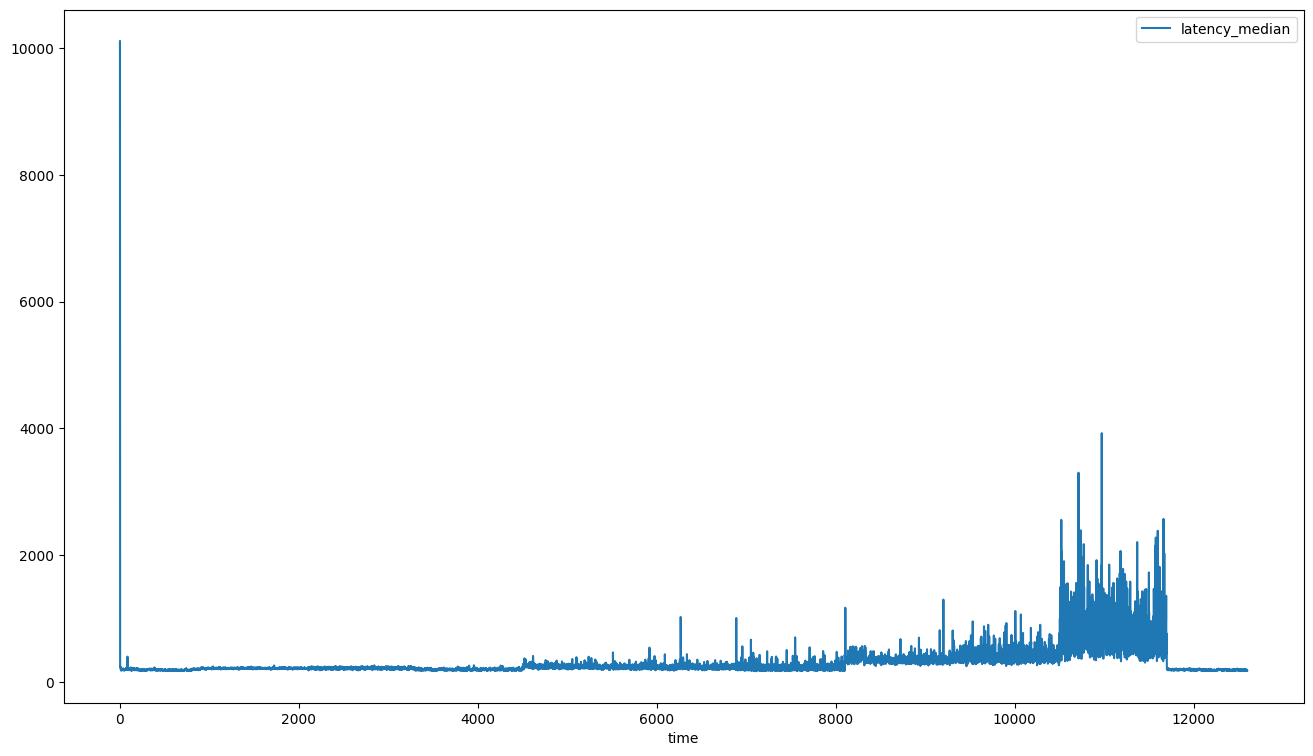

In [126]:
unloaded_df.plot(x='time', y='latency_median', figsize=(16, 9))

<Axes: xlabel='time'>

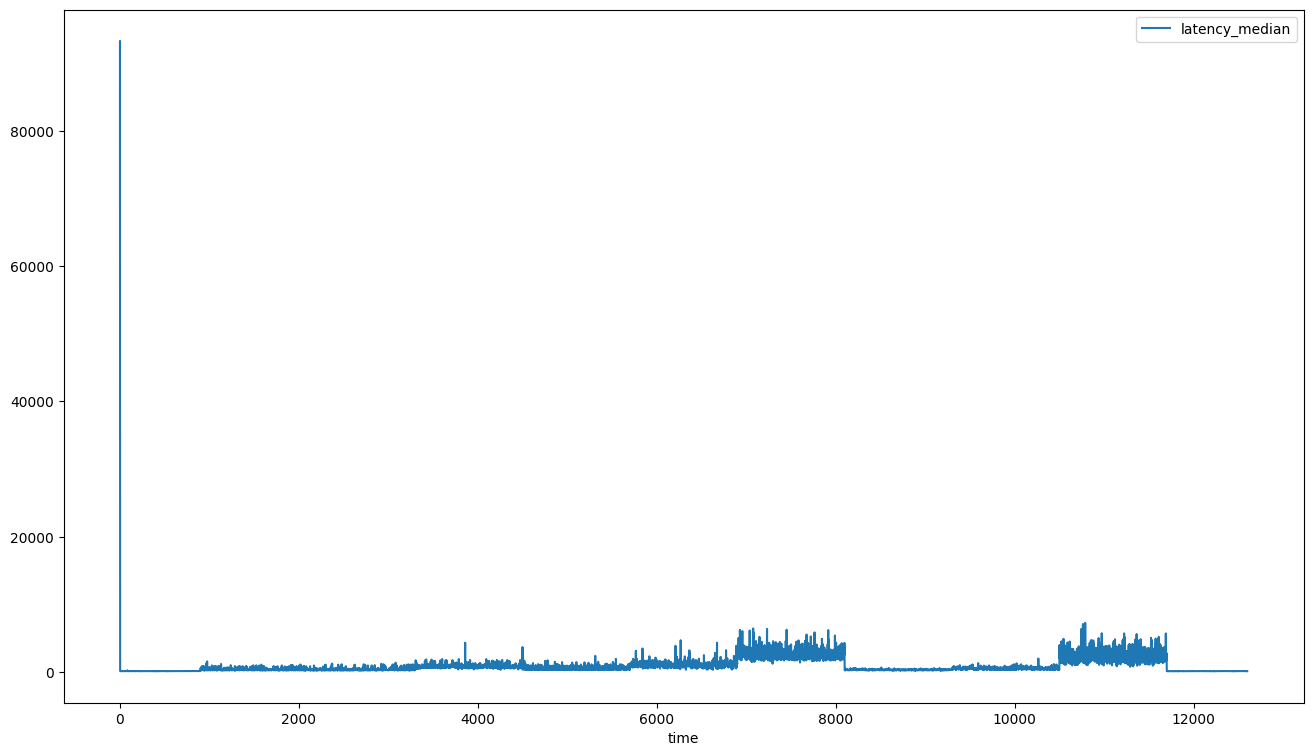

In [127]:
loaded_df.plot(x = 'time', y = 'latency_median', figsize=(16,9))

In [128]:
combinado_df = pd.concat([unloaded_df, loaded_df], ignore_index=True)

In [129]:
correlation_matrix = combinado_df.corr()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()